Processing /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg...
Функция extract_palette выполнялась 0.75 секунд.


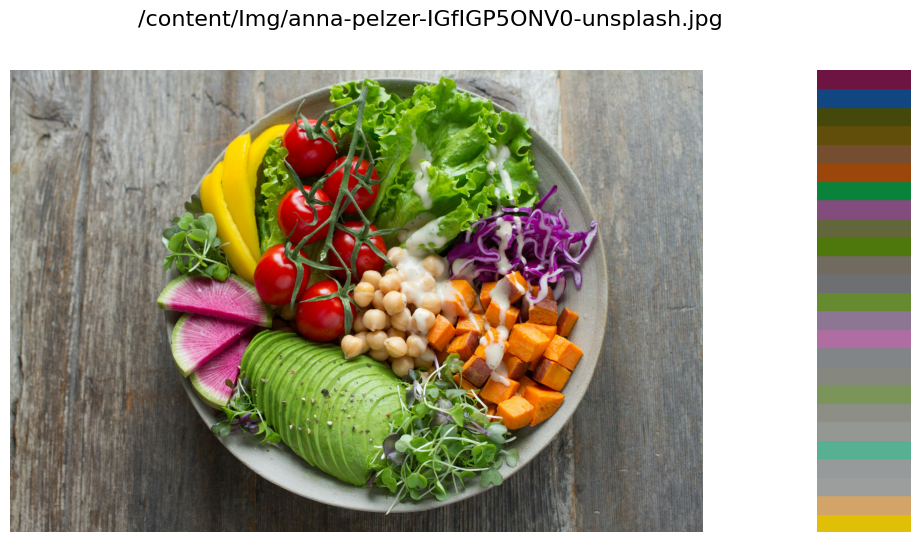

Successfully processed /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg
Processing /content/Img/bird-8666099_640.jpg...
Функция extract_palette выполнялась 0.26 секунд.


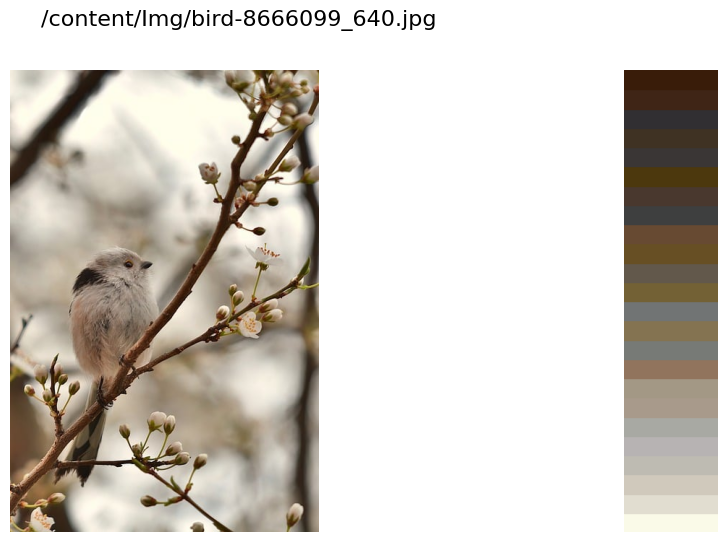

Successfully processed /content/Img/bird-8666099_640.jpg
Processing /content/Img/goose-8740266_640.jpg...
Функция extract_palette выполнялась 0.27 секунд.


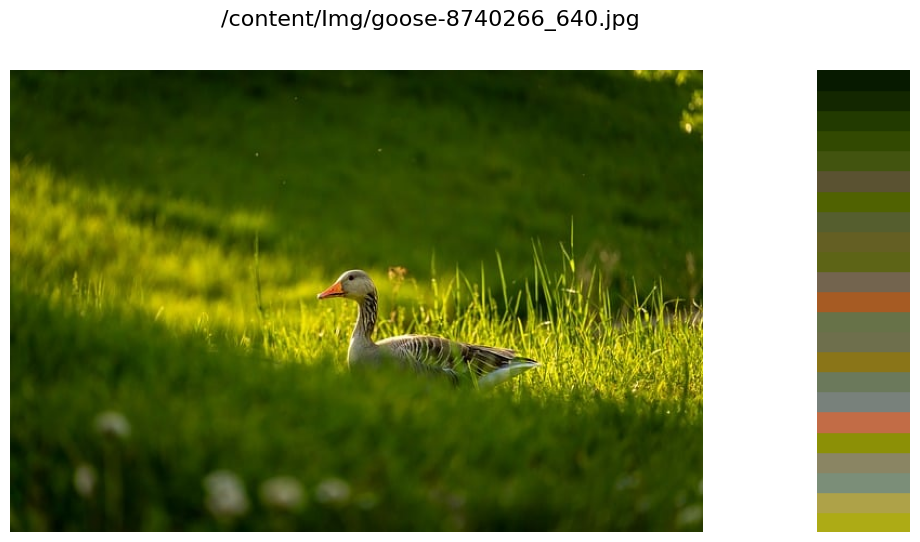

Successfully processed /content/Img/goose-8740266_640.jpg
Processing /content/Img/wild-goose-2260866_640.jpg...
Функция extract_palette выполнялась 0.28 секунд.


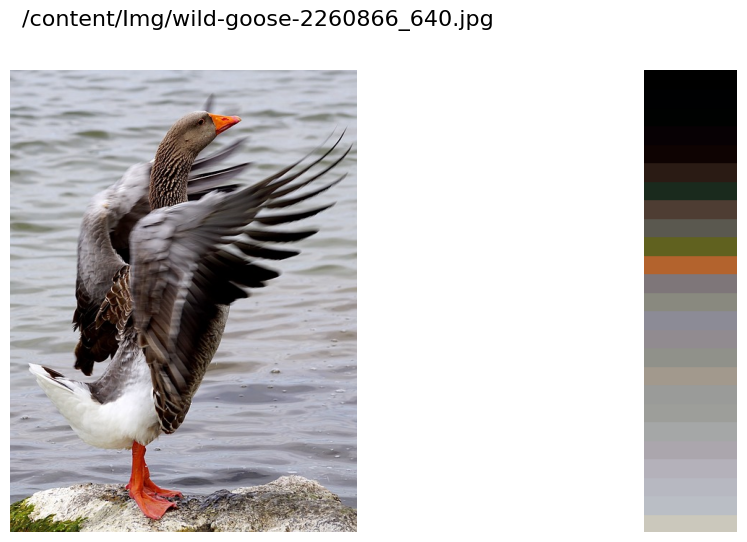

Successfully processed /content/Img/wild-goose-2260866_640.jpg


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import os

# Change the current working directory to 'Pallete' so Python can find local modules like 'timex'
os.chdir('Pallete')

from timex import timex
from sklearn.cluster import KMeans
from IPython.display import display
import colorsys
import random

# Vectorized implementation of RGB to OKLab conversion

def rgb_to_oklab(rgb):
    rgb = rgb.astype(np.float32) / 255.0
    #print(rgb)
    l = 0.4122214708 * rgb[:, 0] + 0.5363325363 * rgb[:, 1] + 0.0514459929 * rgb[:, 2]
    m = 0.2119034982 * rgb[:, 0] + 0.6806995451 * rgb[:, 1] + 0.1073969566 * rgb[:, 2]
    s = 0.0883024619 * rgb[:, 0] + 0.2817188376 * rgb[:, 1] + 0.6299787005 * rgb[:, 2]

    l_ = np.cbrt(l)
    m_ = np.cbrt(m)
    s_ = np.cbrt(s)

    L = 0.2104542553 * l_ + 0.7936177850 * m_ - 0.0040720468 * s_
    a = 1.9779984951 * l_ - 2.4285922050 * m_ + 0.4505937099 * s_
    b = 0.0259040371 * l_ + 0.7827717662 * m_ - 0.8086757660 * s_

    return np.stack([L, a, b], axis=1)

# Vectorized implementation of OKLab to RGB conversion

def oklab_to_rgb(oklab):
    L, a, b = oklab[:, 0], oklab[:, 1], oklab[:, 2]

    l_ = L + 0.3963377774 * a + 0.2158037573 * b
    m_ = L - 0.1055613458 * a - 0.0638541728 * b
    s_ = L - 0.0894841775 * a - 1.2914855480 * b

    l = l_ ** 3
    m = m_ ** 3
    s = s_ ** 3

    r = 4.0767416621 * l - 3.3077115913 * m + 0.2309699292 * s
    g = -1.2684380046 * l + 2.6097574011 * m - 0.3413193965 * s
    b = -0.0041960863 * l - 0.7034186147 * m + 1.7076147010 * s

    rgb = np.clip(np.stack([r, g, b], axis=1), 0, 1) * 255
    return rgb.astype(np.uint8)

# Convert OKLab to cylindrical representation (L, C, h)

def oklab_to_cylindrical(oklab):
    L, a, b = oklab[0], oklab[1], oklab[2]
    C = np.sqrt(a**2 + b**2)
    h = np.arctan2(b, a)
    return np.array([L, C, h])

# Convert cylindrical representation (L, C, h) back to OKLab

def cylindrical_to_oklab(cylindrical):
    L, C, h = cylindrical
    a = C * np.cos(h)
    b = C * np.sin(h)
    return np.array([L, a, b])

def color_distance(color1, color2):
    """Calculate the distance between two OKLab colors using cylindrical coordinates"""
    # Note: Vectorized version for performance
    if color1.ndim == 1 and color2.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2
    elif color1.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]
    elif color2.ndim == 1:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2
    else:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]

    # Calculate Cylindrical coordinates
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    h1 = np.arctan2(b1, a1)
    h2 = np.arctan2(b2, a2)

    # Distance in cylindrical space (L, C, h)
    L_diff = L1 - L2
    C_diff = C1 - C2

    h_diff = np.abs(h1 - h2)
    h_diff = np.minimum(h_diff, 2*np.pi - h_diff)  # Handle hue wrap-around

    return np.sqrt(L_diff**2 + C_diff**2 + h_diff**2)

class WeightedKMeans:
    def __init__(self, k=5, weights=(10.0, 2.0, 1.0), max_iters=10):
        """
        k: Number of colors in palette
        weights: (Hue, Saturation, Value) importance weights
        """
        self.k = k
        self.weights = np.array(weights)
        self.max_iters = max_iters
        self.centroids = []
        self.labels_ = None # To store labels after fit

    def _rgb_to_hsv_array(self, rgb_array):
        """
        Converts an array of RGB (0-255) to HSV (0-1).
        """
        # Normalize to 0-1
        arr = rgb_array / 255.0
        hsv_list = [colorsys.rgb_to_hsv(r, g, b) for r, g, b in arr]
        return np.array(hsv_list)

    def _weighted_distance(self, points, centers):
        """
        Calculates weighted distance between a set of points and a set of centers.
        Returns a matrix of distances.
        """
        # Expand dims for broadcasting: (N_points, 1, 3) - (1, N_centers, 3)
        points_exp = points[:, np.newaxis, :]
        centers_exp = centers[np.newaxis, :, :]

        # 1. Hue Distance (Circular)
        h_diff = np.abs(points_exp[..., 0] - centers_exp[..., 0])
        # The shortest path around the circle (0.0 to 1.0)
        h_dist = np.minimum(h_diff, 1.0 - h_diff)

        # 2. Saturation & Value Distance (Linear)
        s_dist = np.abs(points_exp[..., 1] - centers_exp[..., 1])
        v_dist = np.abs(points_exp[..., 2] - centers_exp[..., 2])

        # 3. Apply Weights
        w_h, w_s, w_v = self.weights

        dist_sq = (w_h * h_dist)**2 + (w_s * s_dist)**2 + (w_v * v_dist)**2

        return np.sqrt(dist_sq)

    def _initialize_centroids(self, data):
        """
        Max-Hue-Distance Initialization (K-Means++ style).
        """
        n_samples = data.shape[0]

        # 1. Pick first centroid randomly
        centroids = [data[random.randint(0, n_samples - 1)]]

        for _ in range(1, self.k):
            # Convert current centroids list to array
            centers_arr = np.array(centroids)

            # Calculate distance from every point to every current centroid
            dists = self._weighted_distance(data, centers_arr)

            # Find the distance to the *nearest* centroid for each point
            min_dists = np.min(dists, axis=1)

            # Select the point that is *farthest* from its nearest centroid
            next_centroid_idx = np.argmax(min_dists)
            centroids.append(data[next_centroid_idx])

        return np.array(centroids)

    def fit(self, pixels):
        """
        pixels: List or array of RGB tuples [(r,g,b), ...]
        """
        # Convert to HSV once
        data = self._rgb_to_hsv_array(np.array(pixels))

        # Step 1: Smart Initialization
        self.centroids = self._initialize_centroids(data)

        for i in range(self.max_iters):
            # Step 2: Assign points to nearest centroid
            dists = self._weighted_distance(data, self.centroids)
            labels = np.argmin(dists, axis=1)

            new_centroids = []
            for k in range(self.k):
                # Get all points assigned to cluster k
                cluster_points = data[labels == k]

                if len(cluster_points) == 0:
                    # Handle empty cluster (keep old centroid)
                    new_centroids.append(self.centroids[k])
                else:
                    # Step 3: Update centroid (Mean of cluster)
                    mean_hsv = cluster_points.mean(axis=0)
                    new_centroids.append(mean_hsv)

            new_centroids = np.array(new_centroids)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        # Store final labels for external access
        dists = self._weighted_distance(data, self.centroids)
        self.labels_ = np.argmin(dists, axis=1)

        return self.centroids

    def get_rgb_centroids(self):
        """Convert final HSV centroids back to RGB 0-255"""
        rgb_centroids = []
        for h, s, v in self.centroids:
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            rgb_centroids.append((int(r*255), int(g*255), int(b*255)))
        return rgb_centroids

def select_furthest_colors(oklab_pixels, num_colors):
    """Select colors that are furthest apart from each other, but also include the most saturated colors"""
    # Subsample pixels if there are too many to speed up initial search
    # 100x100 = 10000 pixels. A subset of 1000 is usually enough for a good palette distribution
    max_sample_size = 1000
    if len(oklab_pixels) > max_sample_size:
        indices = np.random.choice(len(oklab_pixels), max_sample_size, replace=False)
        sampled_pixels = oklab_pixels[indices]
    else:
        sampled_pixels = oklab_pixels

    if len(sampled_pixels) <= num_colors:
        return sampled_pixels

    # --- NEW: Use KMeans to cluster colors first ---
    # We cluster into num_colors / 2 to find general color groups
    # Then we add the cluster center, AND the most saturated color in that cluster
    n_clusters = max(2, num_colors // 2)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(sampled_pixels)
    labels = kmeans.labels_

    selected_colors = []

    for i in range(n_clusters):
        # Get all pixels in this cluster
        cluster_pixels = sampled_pixels[labels == i]
        if len(cluster_pixels) == 0:
            continue

        # 1. Add the center of the cluster (average color)
        # We pick the actual pixel closest to the mathematical center
        center = kmeans.cluster_centers_[i]
        dists_to_center = np.sum((cluster_pixels - center)**2, axis=1)
        closest_to_center = cluster_pixels[np.argmin(dists_to_center)]
        selected_colors.append(closest_to_center)

        # 2. Add the most saturated color in this cluster
        # In OKLab, saturation/chroma is roughly sqrt(a^2 + b^2)
        a_vals = cluster_pixels[:, 1]
        b_vals = cluster_pixels[:, 2]
        chroma = np.sqrt(a_vals**2 + b_vals**2)

        most_saturated_idx = np.argmax(chroma)
        most_saturated_color = cluster_pixels[most_saturated_idx]

        # Only add if it's different enough from the center to avoid duplicates
        if color_distance(closest_to_center, most_saturated_color) > 0.01:
             selected_colors.append(most_saturated_color)

    # Convert to unique array to remove exact duplicates
    selected_colors = np.unique(np.array(selected_colors), axis=0)
    selected_colors = list(selected_colors)

    # --- Fill remaining slots using furthest color algorithm ---
    # If we haven't reached num_colors, use the furthest distance logic to fill the rest
    while len(selected_colors) < num_colors:
        all_distances = np.array([color_distance(sc, sampled_pixels) for sc in selected_colors])
        min_distances = np.min(all_distances, axis=0)

        for sc in selected_colors:
            matches = np.all(sampled_pixels == sc, axis=1)
            min_distances[matches] = -1

        next_color_idx = np.argmax(min_distances)
        if min_distances[next_color_idx] > 0:
            selected_colors.append(sampled_pixels[next_color_idx])
        else:
            break

    # If we accidentally got more than num_colors (unlikely but possible), trim it
    return np.array(selected_colors[:num_colors])

def merge_similar_oklab_colors(oklab_color_counts, distance_threshold):
    """
    Merges colors in a list of (oklab_color, count) tuples that are closer than a given distance_threshold.
    Merges iteratively until no more pairs are found below the threshold.
    The merged color is a weighted average based on counts, and counts are summed.

    Args:
        oklab_color_counts (list): A list of tuples, where each tuple is (oklab_color_array, count).
                                   oklab_color_array is a 1D numpy array representing an OKLab color.
        distance_threshold (float): The maximum distance between two colors to be considered for merging.

    Returns:
        list: A new list of (oklab_color_array, count) tuples with similar colors merged.
    """
    merged_colors = list(oklab_color_counts) # Create a mutable copy

    while True:
        min_dist = float('inf')
        closest_pair_indices = None
        merge_occurred = False

        if len(merged_colors) <= 1: # Cannot merge if 0 or 1 colors
            break

        # Find the closest pair of colors
        for i in range(len(merged_colors)):
            for j in range(i + 1, len(merged_colors)):
                color1, _ = merged_colors[i]
                color2, _ = merged_colors[j]
                dist = color_distance(color1, color2)

                if dist < min_dist:
                    min_dist = dist
                    closest_pair_indices = (i, j)

        # If the closest pair is below the threshold, merge them
        if closest_pair_indices is not None and min_dist < distance_threshold:
            idx1, idx2 = closest_pair_indices

            # Ensure idx1 is always smaller for consistent removal later
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1

            color1, count1 = merged_colors[idx1]
            color2, count2 = merged_colors[idx2]

            # Calculate weighted average color
            total_count = count1 + count2
            # Handle case where total_count might be zero, though unlikely with counts
            if total_count == 0:
                merged_oklab_color = (color1 + color2) / 2 # Simple average if no weight
            else:
                merged_oklab_color = (color1 * count1 + color2 * count2) / total_count

            # Remove original colors and add the new merged color
            # Remove in reverse order to avoid index shifting issues
            del merged_colors[idx2]
            del merged_colors[idx1]
            merged_colors.append((merged_oklab_color, total_count))
            merge_occurred = True

        if not merge_occurred:
            break # No more merges possible below the threshold

    return merged_colors


@timex
def extract_palette(image_path, num_colors, merging_threshold=0.05):
    # Open the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Resize image to reduce the number of pixels for faster processing
    image = image.resize((100, 100))

    # Convert image to numpy array
    image_array = np.array(image)

    # Reshape the image array to be a list of pixels
    pixels = image_array.reshape(-1, 3)

    # Use Weighted K-Means (HSV based) to select colors
    # Strategy: Hue(10) > Saturation(2) > Value(1)
    kmeans = WeightedKMeans(k=num_colors, weights=(10.0, 2.0, 1.0))
    kmeans.fit(pixels)

    # Get initial RGB centroids and their counts
    rgb_centroids_initial = kmeans.get_rgb_centroids()
    counts_initial = np.bincount(kmeans.labels_)

    # Combine colors with their counts and convert to OKLab
    color_with_counts = []
    for i, rgb_color in enumerate(rgb_centroids_initial):
        count = counts_initial[i] if i < len(counts_initial) else 0
        oklab_color = rgb_to_oklab(np.array(rgb_color).reshape(1, 3))[0]
        color_with_counts.append((oklab_color, count))

    # --- Apply merging of similar colors ---
    merged_color_with_counts = merge_similar_oklab_colors(color_with_counts, merging_threshold)

    # Sort the merged colors by L (lightness) and then by h (hue)
    sorted_oklab_color_with_counts = sorted(merged_color_with_counts, key=lambda item: (item[0][0], item[0][2]), reverse=True)

    # Extract sorted OKLab colors and their corresponding counts
    sorted_oklab_colors_only = np.array([item[0] for item in sorted_oklab_color_with_counts])
    sorted_counts = np.array([item[1] for item in sorted_oklab_color_with_counts])

    # Convert sorted OKLab colors back to RGB
    rgb_colors = oklab_to_rgb(sorted_oklab_colors_only)

    # Also calculate oklab_pixels for the projection plot
    oklab_pixels = rgb_to_oklab(pixels)

    return rgb_colors, oklab_pixels, sorted_counts

def plot_palette(colors):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 1, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))

    # Create a color bar
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color) / 255.0))

    plt.xlim(0, len(colors))
    plt.ylim(0, 1)
    plt.show()

def plot_image_with_palette(image_path, colors):
    # Open the image
    image = Image.open(image_path)

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [8, 1]})
    fig.suptitle(image_path, fontsize=16)

    # Display the image
    ax1.imshow(image)
    ax1.axis('off')

    # Create a color bar for the palette
    for i, color in enumerate(colors):
        ax2.add_patch(plt.Rectangle((0, i), 1, 1, color=np.array(color) / 255.0))

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, len(colors))
    ax2.axis('off')

    plt.show()

def plot_ab_projection(image_path, selected_colors, oklab_pixels=None, color_counts=None):
    """Plot pixels projected to a-b space with selected colors highlighted using Plotly"""
    if oklab_pixels is None:
        # Load and process image to get OKLab pixels
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize((100, 100))
        image_array = np.array(image)
        pixels = image_array.reshape(-1, 3)
        oklab_pixels = rgb_to_oklab(pixels)

    # Extract a and b components
    a_values = oklab_pixels[:, 1]
    b_values = oklab_pixels[:, 2]

    # Subsample background pixels for plot performance if too many
    max_bg_points = 5000
    if len(a_values) > max_bg_points:
        indices = np.random.choice(len(a_values), max_bg_points, replace=False)
        a_bg = a_values[indices]
        b_bg = b_values[indices]
    else:
        a_bg = a_values
        b_bg = b_values

    # Convert selected colors to OKLab for projection
    selected_oklab = []
    for rgb_color in selected_colors:
        # Convert RGB to OKLab
        rgb_array = np.array(rgb_color).reshape(1, 3).astype(np.float32)
        oklab_color = rgb_to_oklab(rgb_array)[0]
        selected_oklab.append(oklab_color)

    selected_oklab = np.array(selected_oklab)
    selected_a = selected_oklab[:, 1]
    selected_b = selected_oklab[:, 2]

    # Calculate dynamic bounds with padding
    # Combine all a and b values to find the overall min and max
    all_a_points = np.concatenate([a_values, selected_a])
    all_b_points = np.concatenate([b_values, selected_b])

    min_a, max_a = np.min(all_a_points), np.max(all_a_points)
    min_b, max_b = np.min(all_b_points), np.max(all_b_points)

    # Calculate range to ensure equal aspect ratio
    a_range = max_a - min_a
    b_range = max_b - min_b
    max_range = max(a_range, b_range)

    # Add 10% padding
    padding = max_range * 0.1

    # Center the plot based on data, not origin
    a_center = (max_a + min_a) / 2
    b_center = (max_b + min_b) / 2

    axis_range = [- (max_range / 2) - padding, (max_range / 2) + padding]
    x_range = [a_center + axis_range[0], a_center + axis_range[1]]
    y_range = [b_center + axis_range[0], b_center + axis_range[1]]

    # Create interactive figure
    fig = go.Figure()

    # 1. Plot all background pixels
    fig.add_trace(go.Scatter(
        x=a_bg, y=b_bg,
        mode='markers',
        marker=dict(
            color='lightblue',
            size=3,
            opacity=0.3
        ),
        name='All Pixels (Sampled)',
        hoverinfo='skip'
    ))

    # 2. Add concentric reference circles (only visible within bounds)
    theta = np.linspace(0, 2*np.pi, 100)
    for radius in [0.1, 0.2, 0.3, 0.4, 0.5]: # Reduced radii scale to typical a/b ranges
        circle_a = radius * np.cos(theta)
        circle_b = radius * np.sin(theta)
        fig.add_trace(go.Scatter(
            x=circle_a, y=circle_b,
            mode='lines',
            line=dict(color='gray', width=1, dash='dash'),
            opacity=0.3,
            showlegend=False,
            hoverinfo='skip'
        ))

    # 3. Plot selected colors
    colors_hex = ['#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2])) for c in selected_colors]

    # Determine marker sizes based on color_counts if provided, otherwise default
    if color_counts is not None and len(color_counts) == len(selected_colors):
        marker_sizes = np.log(color_counts + 1) * 5 + 5 # Scale log of count + small base size
    else:
        marker_sizes = 14 # Default size if counts are not available or don't match

    fig.add_trace(go.Scatter(
        x=selected_a, y=selected_b,
        mode='markers+text',
        marker=dict(
            color=colors_hex,
            size=marker_sizes, # Use dynamically calculated sizes
            line=dict(color='black', width=1.5)
        ),
        text=[str(i+1) for i in range(len(selected_a))],
        textposition='top right',
        textfont=dict(size=12, color='black'),
        name='Selected Colors',
        hovertext=[f"Color {i+1}<br>RGB: {tuple(int(x) for x in c)}" for i, c in enumerate(selected_colors)],
        hoverinfo="text"
    ))

    # Update layout for interactive plot
    fig.update_layout(
        title=dict(
            text=f'Interactive OKLab a-b Color Projection - {image_path}',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title='a (green-red axis)',
            range=x_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True,
            scaleanchor="y",
            scaleratio=1
        ),
        yaxis=dict(
            title='b (blue-yellow axis)',
            range=y_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True
        ),
        width=800,
        height=800,
        plot_bgcolor='white',
        hovermode='closest',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    fig.show()

if __name__ == "__main__":
    image_paths = [
        '/content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg',
        '/content/Img/bird-8666099_640.jpg',
        '/content/Img/goose-8740266_640.jpg',
        '/content/Img/wild-goose-2260866_640.jpg'
    ]

    num_colors = 25  # Number of colors in the palette
    merging_threshold = 0.05 # Example merging threshold

    for image_path in image_paths:
        try:
            print(f"Processing {image_path}...")

            # Load and process image to get OKLab pixels for projection
            image = Image.open(image_path)
            image = image.convert('RGB')
            image = image.resize((100, 100))
            image_array = np.array(image)
            pixels = image_array.reshape(-1, 3)
            oklab_pixels = rgb_to_oklab(pixels)

            # Extract palette, now also returning counts and applying merging
            colors, _, counts = extract_palette(image_path, num_colors, merging_threshold)

            # Plot image with palette
            plot_image_with_palette(image_path, colors)

            # Plot a-b projection, passing the counts
            plot_ab_projection(image_path, colors, oklab_pixels, color_counts=counts)

            print(f"Successfully processed {image_path}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

To clone a GitHub repository, you can use the `!git clone` command followed by the repository's URL. For example, to clone a repository named `my-repo` from a user `github-user`:

# Task
Create a palette generation function that uses weighted K-Means clustering to extract `num_colors` from an image, then refines this palette by merging similar colors in OKLab space based on a `merging_threshold`. The function should return the final palette as RGB colors, the original OKLab pixel data for projection, and the counts of pixels contributing to each final palette color.

## Define merge_similar_oklab_colors function

### Subtask:
Add a new helper function `merge_similar_oklab_colors` to the code cell. This function will take a list of `(oklab_color, count)` tuples and a `distance_threshold`. It will iteratively merge the closest pairs of colors that are below the threshold, calculating a new weighted average color and summing their counts, until no more merges are possible.


**Reasoning**:
The subtask requires defining a new function `merge_similar_oklab_colors` that iteratively merges close colors based on a distance threshold. This function will use the previously defined `color_distance` function and perform weighted averaging for colors and sum for counts. I will add this new function to the existing code cell.



Processing /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg...
Функция extract_palette выполнялась 1.37 секунд.


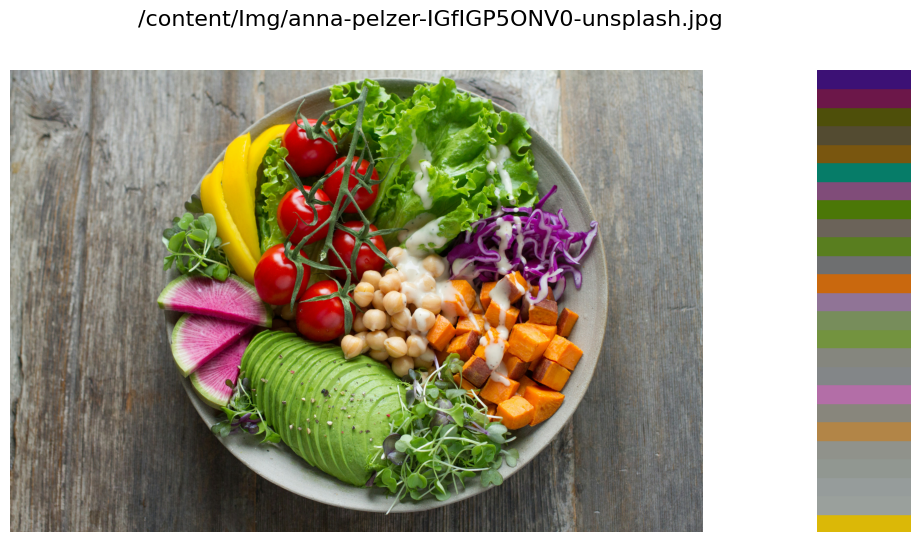

Successfully processed /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg
Processing /content/Img/bird-8666099_640.jpg...
Функция extract_palette выполнялась 0.27 секунд.


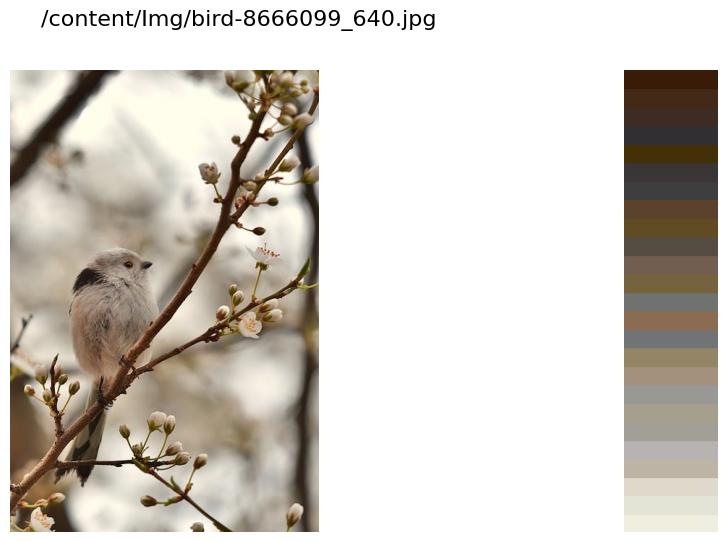

Successfully processed /content/Img/bird-8666099_640.jpg
Processing /content/Img/goose-8740266_640.jpg...
Функция extract_palette выполнялась 0.25 секунд.


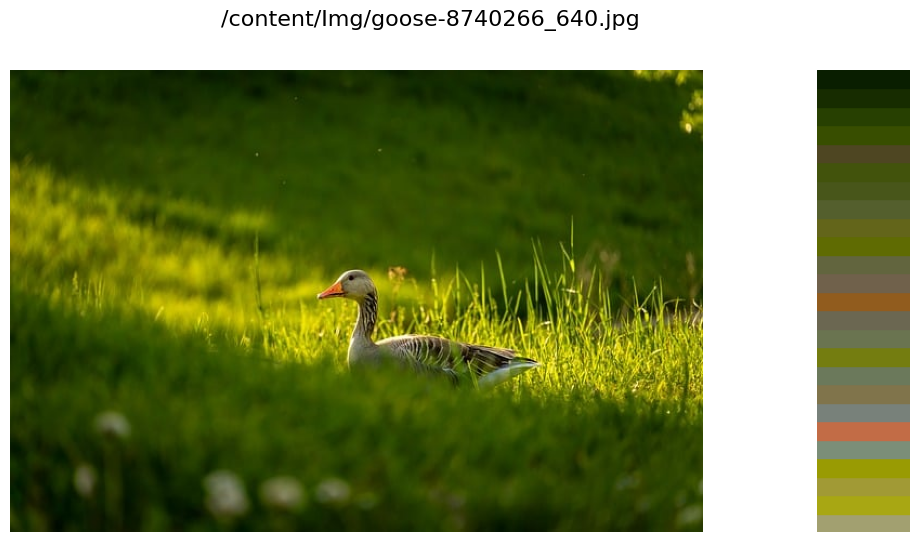

Successfully processed /content/Img/goose-8740266_640.jpg
Processing /content/Img/wild-goose-2260866_640.jpg...
Функция extract_palette выполнялась 0.27 секунд.


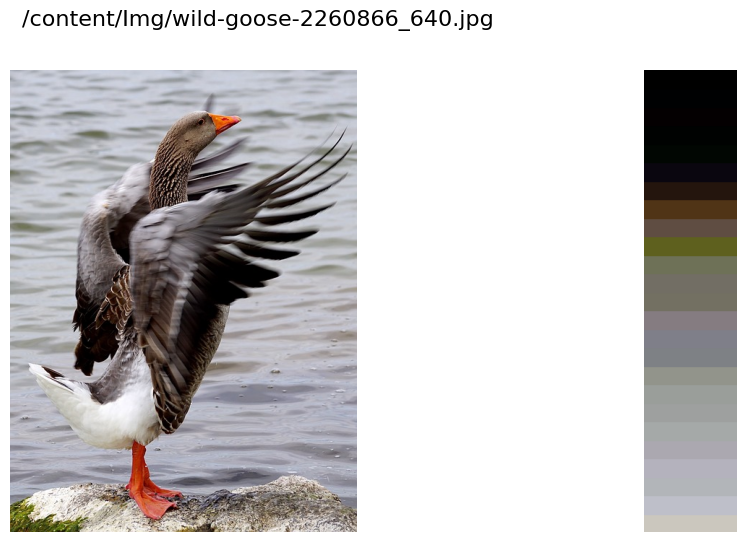

Successfully processed /content/Img/wild-goose-2260866_640.jpg


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import os

# Change the current working directory to 'Pallete' so Python can find local modules like 'timex'
#os.chdir('Pallete')

from timex import timex
from sklearn.cluster import KMeans
from IPython.display import display
import colorsys
import random

# Vectorized implementation of RGB to OKLab conversion

def rgb_to_oklab(rgb):
    rgb = rgb.astype(np.float32) / 255.0
    #print(rgb)
    l = 0.4122214708 * rgb[:, 0] + 0.5363325363 * rgb[:, 1] + 0.0514459929 * rgb[:, 2]
    m = 0.2119034982 * rgb[:, 0] + 0.6806995451 * rgb[:, 1] + 0.1073969566 * rgb[:, 2]
    s = 0.0883024619 * rgb[:, 0] + 0.2817188376 * rgb[:, 1] + 0.6299787005 * rgb[:, 2]

    l_ = np.cbrt(l)
    m_ = np.cbrt(m)
    s_ = np.cbrt(s)

    L = 0.2104542553 * l_ + 0.7936177850 * m_ - 0.0040720468 * s_
    a = 1.9779984951 * l_ - 2.4285922050 * m_ + 0.4505937099 * s_
    b = 0.0259040371 * l_ + 0.7827717662 * m_ - 0.8086757660 * s_

    return np.stack([L, a, b], axis=1)

# Vectorized implementation of OKLab to RGB conversion

def oklab_to_rgb(oklab):
    L, a, b = oklab[:, 0], oklab[:, 1], oklab[:, 2]

    l_ = L + 0.3963377774 * a + 0.2158037573 * b
    m_ = L - 0.1055613458 * a - 0.0638541728 * b
    s_ = L - 0.0894841775 * a - 1.2914855480 * b

    l = l_ ** 3
    m = m_ ** 3
    s = s_ ** 3

    r = 4.0767416621 * l - 3.3077115913 * m + 0.2309699292 * s
    g = -1.2684380046 * l + 2.6097574011 * m - 0.3413193965 * s
    b = -0.0041960863 * l - 0.7034186147 * m + 1.7076147010 * s

    rgb = np.clip(np.stack([r, g, b], axis=1), 0, 1) * 255
    return rgb.astype(np.uint8)

# Convert OKLab to cylindrical representation (L, C, h)

def oklab_to_cylindrical(oklab):
    L, a, b = oklab[0], oklab[1], oklab[2]
    C = np.sqrt(a**2 + b**2)
    h = np.arctan2(b, a)
    return np.array([L, C, h])

# Convert cylindrical representation (L, C, h) back to OKLab

def cylindrical_to_oklab(cylindrical):
    L, C, h = cylindrical
    a = C * np.cos(h)
    b = C * np.sin(h)
    return np.array([L, a, b])

def color_distance(color1, color2):
    """Calculate the distance between two OKLab colors using cylindrical coordinates"""
    # Note: Vectorized version for performance
    if color1.ndim == 1 and color2.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2
    elif color1.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]
    elif color2.ndim == 1:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2
    else:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]

    # Calculate Cylindrical coordinates
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    h1 = np.arctan2(b1, a1)
    h2 = np.arctan2(b2, a2)

    # Distance in cylindrical space (L, C, h)
    L_diff = L1 - L2
    C_diff = C1 - C2

    h_diff = np.abs(h1 - h2)
    h_diff = np.minimum(h_diff, 2*np.pi - h_diff)  # Handle hue wrap-around

    return np.sqrt(L_diff**2 + C_diff**2 + h_diff**2)

class WeightedKMeans:
    def __init__(self, k=5, weights=(10.0, 2.0, 1.0), max_iters=10):
        """
        k: Number of colors in palette
        weights: (Hue, Saturation, Value) importance weights
        """
        self.k = k
        self.weights = np.array(weights)
        self.max_iters = max_iters
        self.centroids = []
        self.labels_ = None # To store labels after fit

    def _rgb_to_hsv_array(self, rgb_array):
        """
        Converts an array of RGB (0-255) to HSV (0-1).
        """
        # Normalize to 0-1
        arr = rgb_array / 255.0
        hsv_list = [colorsys.rgb_to_hsv(r, g, b) for r, g, b in arr]
        return np.array(hsv_list)

    def _weighted_distance(self, points, centers):
        """
        Calculates weighted distance between a set of points and a set of centers.
        Returns a matrix of distances.
        """
        # Expand dims for broadcasting: (N_points, 1, 3) - (1, N_centers, 3)
        points_exp = points[:, np.newaxis, :]
        centers_exp = centers[np.newaxis, :, :]

        # 1. Hue Distance (Circular)
        h_diff = np.abs(points_exp[..., 0] - centers_exp[..., 0])
        # The shortest path around the circle (0.0 to 1.0)
        h_dist = np.minimum(h_diff, 1.0 - h_diff)

        # 2. Saturation & Value Distance (Linear)
        s_dist = np.abs(points_exp[..., 1] - centers_exp[..., 1])
        v_dist = np.abs(points_exp[..., 2] - centers_exp[..., 2])

        # 3. Apply Weights
        w_h, w_s, w_v = self.weights

        dist_sq = (w_h * h_dist)**2 + (w_s * s_dist)**2 + (w_v * v_dist)**2

        return np.sqrt(dist_sq)

    def _initialize_centroids(self, data):
        """
        Max-Hue-Distance Initialization (K-Means++ style).
        """
        n_samples = data.shape[0]

        # 1. Pick first centroid randomly
        centroids = [data[random.randint(0, n_samples - 1)]]

        for _ in range(1, self.k):
            # Convert current centroids list to array
            centers_arr = np.array(centroids)

            # Calculate distance from every point to every current centroid
            dists = self._weighted_distance(data, centers_arr)

            # Find the distance to the *nearest* centroid for each point
            min_dists = np.min(dists, axis=1)

            # Select the point that is *farthest* from its nearest centroid
            next_centroid_idx = np.argmax(min_dists)
            centroids.append(data[next_centroid_idx])

        return np.array(centroids)

    def fit(self, pixels):
        """
        pixels: List or array of RGB tuples [(r,g,b), ...]
        """
        # Convert to HSV once
        data = self._rgb_to_hsv_array(np.array(pixels))

        # Step 1: Smart Initialization
        self.centroids = self._initialize_centroids(data)

        for i in range(self.max_iters):
            # Step 2: Assign points to nearest centroid
            dists = self._weighted_distance(data, self.centroids)
            labels = np.argmin(dists, axis=1)

            new_centroids = []
            for k in range(self.k):
                # Get all points assigned to cluster k
                cluster_points = data[labels == k]

                if len(cluster_points) == 0:
                    # Handle empty cluster (keep old centroid)
                    new_centroids.append(self.centroids[k])
                else:
                    # Step 3: Update centroid (Mean of cluster)
                    mean_hsv = cluster_points.mean(axis=0)
                    new_centroids.append(mean_hsv)

            new_centroids = np.array(new_centroids)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        # Store final labels for external access
        dists = self._weighted_distance(data, self.centroids)
        self.labels_ = np.argmin(dists, axis=1)

        return self.centroids

    def get_rgb_centroids(self):
        """Convert final HSV centroids back to RGB 0-255"""
        rgb_centroids = []
        for h, s, v in self.centroids:
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            rgb_centroids.append((int(r*255), int(g*255), int(b*255)))
        return rgb_centroids

def select_furthest_colors(oklab_pixels, num_colors):
    """Select colors that are furthest apart from each other, but also include the most saturated colors"""
    # Subsample pixels if there are too many to speed up initial search
    # 100x100 = 10000 pixels. A subset of 1000 is usually enough for a good palette distribution
    max_sample_size = 1000
    if len(oklab_pixels) > max_sample_size:
        indices = np.random.choice(len(oklab_pixels), max_sample_size, replace=False)
        sampled_pixels = oklab_pixels[indices]
    else:
        sampled_pixels = oklab_pixels

    if len(sampled_pixels) <= num_colors:
        return sampled_pixels

    # --- NEW: Use KMeans to cluster colors first ---
    # We cluster into num_colors / 2 to find general color groups
    # Then we add the cluster center, AND the most saturated color in that cluster
    n_clusters = max(2, num_colors // 2)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(sampled_pixels)
    labels = kmeans.labels_

    selected_colors = []

    for i in range(n_clusters):
        # Get all pixels in this cluster
        cluster_pixels = sampled_pixels[labels == i]
        if len(cluster_pixels) == 0:
            continue

        # 1. Add the center of the cluster (average color)
        # We pick the actual pixel closest to the mathematical center
        center = kmeans.cluster_centers_[i]
        dists_to_center = np.sum((cluster_pixels - center)**2, axis=1)
        closest_to_center = cluster_pixels[np.argmin(dists_to_center)]
        selected_colors.append(closest_to_center)

        # 2. Add the most saturated color in this cluster
        # In OKLab, saturation/chroma is roughly sqrt(a^2 + b^2)
        a_vals = cluster_pixels[:, 1]
        b_vals = cluster_pixels[:, 2]
        chroma = np.sqrt(a_vals**2 + b_vals**2)

        most_saturated_idx = np.argmax(chroma)
        most_saturated_color = cluster_pixels[most_saturated_idx]

        # Only add if it's different enough from the center to avoid duplicates
        if color_distance(closest_to_center, most_saturated_color) > 0.01:
             selected_colors.append(most_saturated_color)

    # Convert to unique array to remove exact duplicates
    selected_colors = np.unique(np.array(selected_colors), axis=0)
    selected_colors = list(selected_colors)

    # --- Fill remaining slots using furthest color algorithm ---
    # If we haven't reached num_colors, use the furthest distance logic to fill the rest
    while len(selected_colors) < num_colors:
        all_distances = np.array([color_distance(sc, sampled_pixels) for sc in selected_colors])
        min_distances = np.min(all_distances, axis=0)

        for sc in selected_colors:
            matches = np.all(sampled_pixels == sc, axis=1)
            min_distances[matches] = -1

        next_color_idx = np.argmax(min_dists)
        if min_distances[next_color_idx] > 0:
            selected_colors.append(sampled_pixels[next_color_idx])
        else:
            break

    # If we accidentally got more than num_colors (unlikely but possible), trim it
    return np.array(selected_colors[:num_colors])

def merge_similar_oklab_colors(oklab_color_counts, distance_threshold):
    """
    Merges colors in a list of (oklab_color, count) tuples that are closer than a given distance_threshold.
    Merges iteratively until no more pairs are found below the threshold.
    The merged color is a weighted average based on counts, and counts are summed.

    Args:
        oklab_color_counts (list): A list of tuples, where each tuple is (oklab_color_array, count).
                                   oklab_color_array is a 1D numpy array representing an OKLab color.
        distance_threshold (float): The maximum distance between two colors to be considered for merging.

    Returns:
        list: A new list of (oklab_color_array, count) tuples with similar colors merged.
    """
    merged_colors = list(oklab_color_counts) # Create a mutable copy

    while True:
        min_dist = float('inf')
        closest_pair_indices = None
        merge_occurred = False

        if len(merged_colors) <= 1: # Cannot merge if 0 or 1 colors
            break

        # Find the closest pair of colors
        for i in range(len(merged_colors)):
            for j in range(i + 1, len(merged_colors)):
                color1, _ = merged_colors[i]
                color2, _ = merged_colors[j]
                dist = color_distance(color1, color2)

                if dist < min_dist:
                    min_dist = dist
                    closest_pair_indices = (i, j)

        # If the closest pair is below the threshold, merge them
        if closest_pair_indices is not None and min_dist < distance_threshold:
            idx1, idx2 = closest_pair_indices

            # Ensure idx1 is always smaller for consistent removal later
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1

            color1, count1 = merged_colors[idx1]
            color2, count2 = merged_colors[idx2]

            # Calculate weighted average color
            total_count = count1 + count2
            # Handle case where total_count might be zero, though unlikely with counts
            if total_count == 0:
                merged_oklab_color = (color1 + color2) / 2 # Simple average if no weight
            else:
                merged_oklab_color = (color1 * count1 + color2 * count2) / total_count

            # Remove original colors and add the new merged color
            # Remove in reverse order to avoid index shifting issues
            del merged_colors[idx2]
            del merged_colors[idx1]
            merged_colors.append((merged_oklab_color, total_count))
            merge_occurred = True

        if not merge_occurred:
            break # No more merges possible below the threshold

    return merged_colors


@timex
def extract_palette(image_path, num_colors):
    # Open the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Resize image to reduce the number of pixels for faster processing
    image = image.resize((100, 100))

    # Convert image to numpy array
    image_array = np.array(image)

    # Reshape the image array to be a list of pixels
    pixels = image_array.reshape(-1, 3)

    # Use Weighted K-Means (HSV based) to select colors
    # Strategy: Hue(10) > Saturation(2) > Value(1)
    kmeans = WeightedKMeans(k=num_colors, weights=(10.0, 2.0, 1.0))
    kmeans.fit(pixels)

    # Get initial RGB centroids and their counts
    rgb_centroids_initial = kmeans.get_rgb_centroids()
    counts_initial = np.bincount(kmeans.labels_)

    # Combine colors with their counts and convert to OKLab for sorting
    color_with_counts = []
    for i, rgb_color in enumerate(rgb_centroids_initial):
        # Ensure we don't try to access an out-of-bounds index for counts_initial
        count = counts_initial[i] if i < len(counts_initial) else 0
        oklab_color = rgb_to_oklab(np.array(rgb_color).reshape(1, 3))[0]
        color_with_counts.append((oklab_color, count))

    # Sort the colors by L (lightness) and then by h (hue)
    sorted_oklab_color_with_counts = sorted(color_with_counts, key=lambda item: (item[0][0], item[0][2]), reverse=True)

    # Extract sorted OKLab colors and their corresponding counts
    sorted_oklab_colors_only = np.array([item[0] for item in sorted_oklab_color_with_counts])
    sorted_counts = np.array([item[1] for item in sorted_oklab_color_with_counts])

    # Convert sorted OKLab colors back to RGB
    rgb_colors = oklab_to_rgb(sorted_oklab_colors_only)

    # Also calculate oklab_pixels for the projection plot
    oklab_pixels = rgb_to_oklab(pixels)

    return rgb_colors, oklab_pixels, sorted_counts

def plot_palette(colors):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 1, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))

    # Create a color bar
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color) / 255.0))

    plt.xlim(0, len(colors))
    plt.ylim(0, 1)
    plt.show()

def plot_image_with_palette(image_path, colors):
    # Open the image
    image = Image.open(image_path)

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [8, 1]})
    fig.suptitle(image_path, fontsize=16)

    # Display the image
    ax1.imshow(image)
    ax1.axis('off')

    # Create a color bar for the palette
    for i, color in enumerate(colors):
        ax2.add_patch(plt.Rectangle((0, i), 1, 1, color=np.array(color) / 255.0))

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, len(colors))
    ax2.axis('off')

    plt.show()

def plot_ab_projection(image_path, selected_colors, oklab_pixels=None, color_counts=None):
    """Plot pixels projected to a-b space with selected colors highlighted using Plotly"""
    if oklab_pixels is None:
        # Load and process image to get OKLab pixels
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize((100, 100))
        image_array = np.array(image)
        pixels = image_array.reshape(-1, 3)
        oklab_pixels = rgb_to_oklab(pixels)

    # Extract a and b components
    a_values = oklab_pixels[:, 1]
    b_values = oklab_pixels[:, 2]

    # Subsample background pixels for plot performance if too many
    max_bg_points = 5000
    if len(a_values) > max_bg_points:
        indices = np.random.choice(len(a_values), max_bg_points, replace=False)
        a_bg = a_values[indices]
        b_bg = b_values[indices]
    else:
        a_bg = a_values
        b_bg = b_values

    # Convert selected colors to OKLab for projection
    selected_oklab = []
    for rgb_color in selected_colors:
        # Convert RGB to OKLab
        rgb_array = np.array(rgb_color).reshape(1, 3).astype(np.float32)
        oklab_color = rgb_to_oklab(rgb_array)[0]
        selected_oklab.append(oklab_color)

    selected_oklab = np.array(selected_oklab)
    selected_a = selected_oklab[:, 1]
    selected_b = selected_oklab[:, 2]

    # Calculate dynamic bounds with padding
    # Combine all a and b values to find the overall min and max
    all_a_points = np.concatenate([a_values, selected_a])
    all_b_points = np.concatenate([b_values, selected_b])

    min_a, max_a = np.min(all_a_points), np.max(all_a_points)
    min_b, max_b = np.min(all_b_points), np.max(all_b_points)

    # Calculate range to ensure equal aspect ratio
    a_range = max_a - min_a
    b_range = max_b - min_b
    max_range = max(a_range, b_range)

    # Add 10% padding
    padding = max_range * 0.1

    # Center the plot based on data, not origin
    a_center = (max_a + min_a) / 2
    b_center = (max_b + min_b) / 2

    axis_range = [- (max_range / 2) - padding, (max_range / 2) + padding]
    x_range = [a_center + axis_range[0], a_center + axis_range[1]]
    y_range = [b_center + axis_range[0], b_center + axis_range[1]]

    # Create interactive figure
    fig = go.Figure()

    # 1. Plot all background pixels
    fig.add_trace(go.Scatter(
        x=a_bg, y=b_bg,
        mode='markers',
        marker=dict(
            color='lightblue',
            size=3,
            opacity=0.3
        ),
        name='All Pixels (Sampled)',
        hoverinfo='skip'
    ))

    # 2. Add concentric reference circles (only visible within bounds)
    theta = np.linspace(0, 2*np.pi, 100)
    for radius in [0.1, 0.2, 0.3, 0.4, 0.5]: # Reduced radii scale to typical a/b ranges
        circle_a = radius * np.cos(theta)
        circle_b = radius * np.sin(theta)
        fig.add_trace(go.Scatter(
            x=circle_a, y=circle_b,
            mode='lines',
            line=dict(color='gray', width=1, dash='dash'),
            opacity=0.3,
            showlegend=False,
            hoverinfo='skip'
        ))

    # 3. Plot selected colors
    colors_hex = ['#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2])) for c in selected_colors]

    # Determine marker sizes based on color_counts if provided, otherwise default
    if color_counts is not None and len(color_counts) == len(selected_colors):
        marker_sizes = np.log(color_counts + 1) * 5 + 5 # Scale log of count + small base size
    else:
        marker_sizes = 14 # Default size if counts are not available or don't match

    fig.add_trace(go.Scatter(
        x=selected_a, y=selected_b,
        mode='markers+text',
        marker=dict(
            color=colors_hex,
            size=marker_sizes, # Use dynamically calculated sizes
            line=dict(color='black', width=1.5)
        ),
        text=[str(i+1) for i in range(len(selected_a))],
        textposition='top right',
        textfont=dict(size=12, color='black'),
        name='Selected Colors',
        hovertext=[f"Color {i+1}<br>RGB: {tuple(int(x) for x in c)}" for i, c in enumerate(selected_colors)],
        hoverinfo="text"
    ))

    # Update layout for interactive plot
    fig.update_layout(
        title=dict(
            text=f'Interactive OKLab a-b Color Projection - {image_path}',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title='a (green-red axis)',
            range=x_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True,
            scaleanchor="y",
            scaleratio=1
        ),
        yaxis=dict(
            title='b (blue-yellow axis)',
            range=y_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True
        ),
        width=800,
        height=800,
        plot_bgcolor='white',
        hovermode='closest',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    fig.show()

if __name__ == "__main__":
    image_paths = [
        '/content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg',
        '/content/Img/bird-8666099_640.jpg',
        '/content/Img/goose-8740266_640.jpg',
        '/content/Img/wild-goose-2260866_640.jpg'
    ]

    num_colors = 25  # Number of colors in the palette

    for image_path in image_paths:
        try:
            print(f"Processing {image_path}...")

            # Load and process image to get OKLab pixels for projection
            image = Image.open(image_path)
            image = image.convert('RGB')
            image = image.resize((100, 100))
            image_array = np.array(image)
            pixels = image_array.reshape(-1, 3)
            oklab_pixels = rgb_to_oklab(pixels)

            # Extract palette, now also returning counts
            colors, _, counts = extract_palette(image_path, num_colors)

            # Plot image with palette
            plot_image_with_palette(image_path, colors)

            # Plot a-b projection, passing the counts
            plot_ab_projection(image_path, colors, oklab_pixels, color_counts=counts)

            print(f"Successfully processed {image_path}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

**Reasoning**:
I need to integrate the newly defined `merge_similar_oklab_colors` function into the `extract_palette` function and the main execution block. This involves adding a `merging_threshold` parameter to `extract_palette` and then calling `merge_similar_oklab_colors` within it. Finally, the main execution block will call `extract_palette` with the new threshold and display the results using the updated palette.



Processing /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg...
Функция extract_palette выполнялась 1.91 секунд.


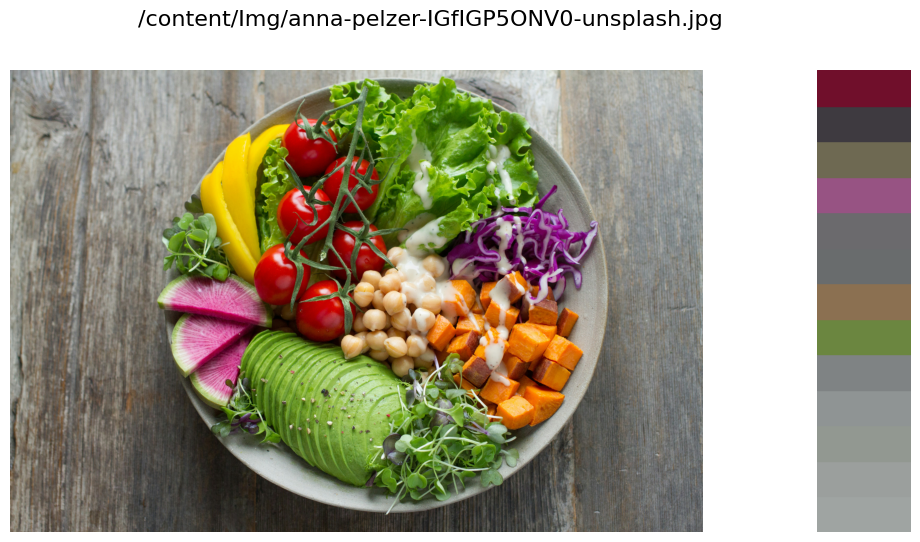

Successfully processed /content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg
Processing /content/Img/bird-8666099_640.jpg...
Функция extract_palette выполнялась 2.09 секунд.


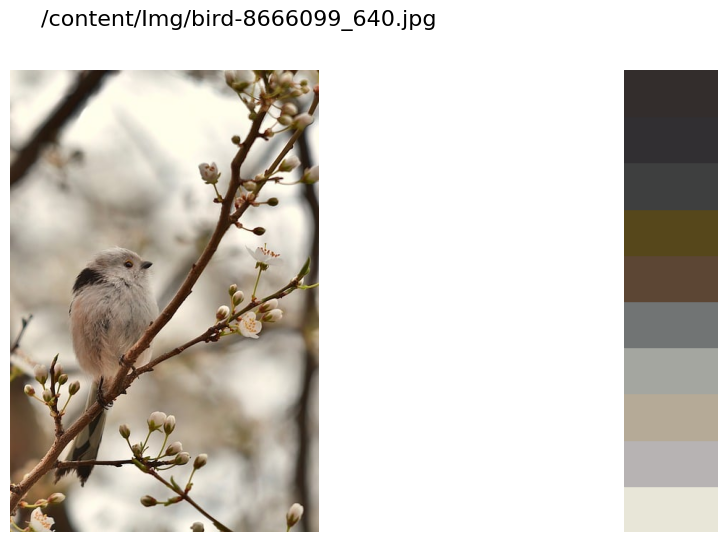

Successfully processed /content/Img/bird-8666099_640.jpg
Processing /content/Img/goose-8740266_640.jpg...
Функция extract_palette выполнялась 1.65 секунд.


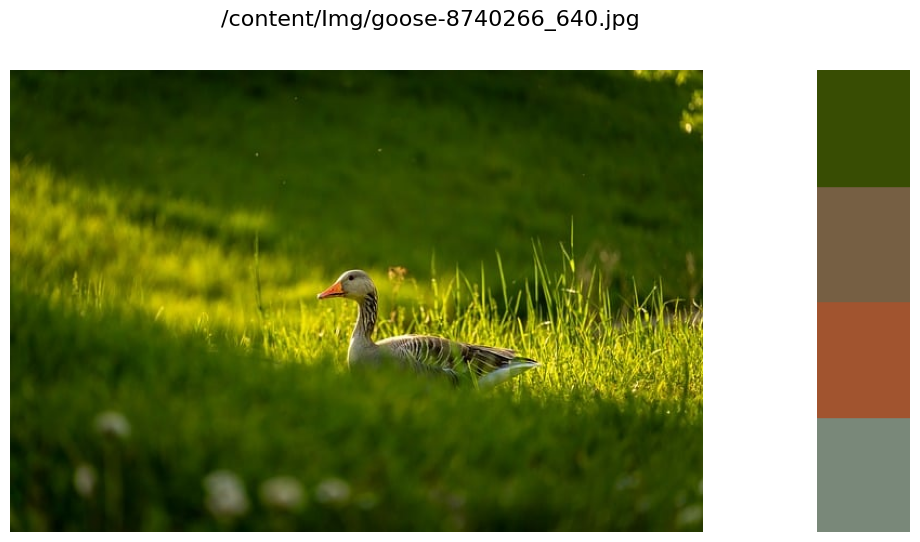

Successfully processed /content/Img/goose-8740266_640.jpg
Processing /content/Img/wild-goose-2260866_640.jpg...
Функция extract_palette выполнялась 1.35 секунд.


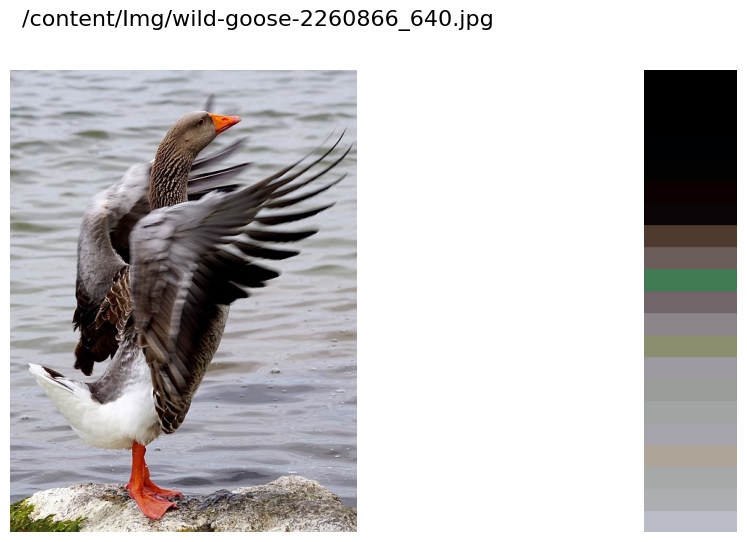

Successfully processed /content/Img/wild-goose-2260866_640.jpg


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import os

# Change the current working directory to 'Pallete' so Python can find local modules like 'timex'
#os.chdir('Pallete')

from timex import timex
from sklearn.cluster import KMeans
from IPython.display import display
import colorsys
import random

# Vectorized implementation of RGB to OKLab conversion

def rgb_to_oklab(rgb):
    rgb = rgb.astype(np.float32) / 255.0
    #print(rgb)
    l = 0.4122214708 * rgb[:, 0] + 0.5363325363 * rgb[:, 1] + 0.0514459929 * rgb[:, 2]
    m = 0.2119034982 * rgb[:, 0] + 0.6806995451 * rgb[:, 1] + 0.1073969566 * rgb[:, 2]
    s = 0.0883024619 * rgb[:, 0] + 0.2817188376 * rgb[:, 1] + 0.6299787005 * rgb[:, 2]

    l_ = np.cbrt(l)
    m_ = np.cbrt(m)
    s_ = np.cbrt(s)

    L = 0.2104542553 * l_ + 0.7936177850 * m_ - 0.0040720468 * s_
    a = 1.9779984951 * l_ - 2.4285922050 * m_ + 0.4505937099 * s_
    b = 0.0259040371 * l_ + 0.7827717662 * m_ - 0.8086757660 * s_

    return np.stack([L, a, b], axis=1)

# Vectorized implementation of OKLab to RGB conversion

def oklab_to_rgb(oklab):
    L, a, b = oklab[:, 0], oklab[:, 1], oklab[:, 2]

    l_ = L + 0.3963377774 * a + 0.2158037573 * b
    m_ = L - 0.1055613458 * a - 0.0638541728 * b
    s_ = L - 0.0894841775 * a - 1.2914855480 * b

    l = l_ ** 3
    m = m_ ** 3
    s = s_ ** 3

    r = 4.0767416621 * l - 3.3077115913 * m + 0.2309699292 * s
    g = -1.2684380046 * l + 2.6097574011 * m - 0.3413193965 * s
    b = -0.0041960863 * l - 0.7034186147 * m + 1.7076147010 * s

    rgb = np.clip(np.stack([r, g, b], axis=1), 0, 1) * 255
    return rgb.astype(np.uint8)

# Convert OKLab to cylindrical representation (L, C, h)

def oklab_to_cylindrical(oklab):
    L, a, b = oklab[0], oklab[1], oklab[2]
    C = np.sqrt(a**2 + b**2)
    h = np.arctan2(b, a)
    return np.array([L, C, h])

# Convert cylindrical representation (L, C, h) back to OKLab

def cylindrical_to_oklab(cylindrical):
    L, C, h = cylindrical
    a = C * np.cos(h)
    b = C * np.sin(h)
    return np.array([L, a, b])

def color_distance(color1, color2):
    """Calculate the distance between two OKLab colors using cylindrical coordinates"""
    # Note: Vectorized version for performance
    if color1.ndim == 1 and color2.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2
    elif color1.ndim == 1:
        L1, a1, b1 = color1
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]
    elif color2.ndim == 1:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2
    else:
        L1, a1, b1 = color1[:, 0], color1[:, 1], color1[:, 2]
        L2, a2, b2 = color2[:, 0], color2[:, 1], color2[:, 2]

    # Calculate Cylindrical coordinates
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    h1 = np.arctan2(b1, a1)
    h2 = np.arctan2(b2, a2)

    # Distance in cylindrical space (L, C, h)
    L_diff = L1 - L2
    C_diff = C1 - C2

    h_diff = np.abs(h1 - h2)
    h_diff = np.minimum(h_diff, 2*np.pi - h_diff)  # Handle hue wrap-around

    return np.sqrt(L_diff**2 + C_diff**2 + h_diff**2)

class WeightedKMeans:
    def __init__(self, k=5, weights=(10.0, 2.0, 1.0), max_iters=10):
        """
        k: Number of colors in palette
        weights: (Hue, Saturation, Value) importance weights
        """
        self.k = k
        self.weights = np.array(weights)
        self.max_iters = max_iters
        self.centroids = []
        self.labels_ = None # To store labels after fit

    def _rgb_to_hsv_array(self, rgb_array):
        """
        Converts an array of RGB (0-255) to HSV (0-1).
        """
        # Normalize to 0-1
        arr = rgb_array / 255.0
        hsv_list = [colorsys.rgb_to_hsv(r, g, b) for r, g, b in arr]
        return np.array(hsv_list)

    def _weighted_distance(self, points, centers):
        """
        Calculates weighted distance between a set of points and a set of centers.
        Returns a matrix of distances.
        """
        # Expand dims for broadcasting: (N_points, 1, 3) - (1, N_centers, 3)
        points_exp = points[:, np.newaxis, :]
        centers_exp = centers[np.newaxis, :, :]

        # 1. Hue Distance (Circular)
        h_diff = np.abs(points_exp[..., 0] - centers_exp[..., 0])
        # The shortest path around the circle (0.0 to 1.0)
        h_dist = np.minimum(h_diff, 1.0 - h_diff)

        # 2. Saturation & Value Distance (Linear)
        s_dist = np.abs(points_exp[..., 1] - centers_exp[..., 1])
        v_dist = np.abs(points_exp[..., 2] - centers_exp[..., 2])

        # 3. Apply Weights
        w_h, w_s, w_v = self.weights

        dist_sq = (w_h * h_dist)**2 + (w_s * s_dist)**2 + (w_v * v_dist)**2

        return np.sqrt(dist_sq)

    def _initialize_centroids(self, data):
        """
        Max-Hue-Distance Initialization (K-Means++ style).
        """
        n_samples = data.shape[0]

        # 1. Pick first centroid randomly
        centroids = [data[random.randint(0, n_samples - 1)]]

        for _ in range(1, self.k):
            # Convert current centroids list to array
            centers_arr = np.array(centroids)

            # Calculate distance from every point to every current centroid
            dists = self._weighted_distance(data, centers_arr)

            # Find the distance to the *nearest* centroid for each point
            min_dists = np.min(dists, axis=1)

            # Select the point that is *farthest* from its nearest centroid
            next_centroid_idx = np.argmax(min_dists)
            centroids.append(data[next_centroid_idx])

        return np.array(centroids)

    def fit(self, pixels):
        """
        pixels: List or array of RGB tuples [(r,g,b), ...]
        """
        # Convert to HSV once
        data = self._rgb_to_hsv_array(np.array(pixels))

        # Step 1: Smart Initialization
        self.centroids = self._initialize_centroids(data)

        for i in range(self.max_iters):
            # Step 2: Assign points to nearest centroid
            dists = self._weighted_distance(data, self.centroids)
            labels = np.argmin(dists, axis=1)

            new_centroids = []
            for k in range(self.k):
                # Get all points assigned to cluster k
                cluster_points = data[labels == k]

                if len(cluster_points) == 0:
                    # Handle empty cluster (keep old centroid)
                    new_centroids.append(self.centroids[k])
                else:
                    # Step 3: Update centroid (Mean of cluster)
                    mean_hsv = cluster_points.mean(axis=0)
                    new_centroids.append(mean_hsv)

            new_centroids = np.array(new_centroids)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        # Store final labels for external access
        dists = self._weighted_distance(data, self.centroids)
        self.labels_ = np.argmin(dists, axis=1)

        return self.centroids

    def get_rgb_centroids(self):
        """Convert final HSV centroids back to RGB 0-255"""
        rgb_centroids = []
        for h, s, v in self.centroids:
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            rgb_centroids.append((int(r*255), int(g*255), int(b*255)))
        return rgb_centroids

def select_furthest_colors(oklab_pixels, num_colors):
    """Select colors that are furthest apart from each other, but also include the most saturated colors"""
    # Subsample pixels if there are too many to speed up initial search
    # 100x100 = 10000 pixels. A subset of 1000 is usually enough for a good palette distribution
    max_sample_size = 1000
    if len(oklab_pixels) > max_sample_size:
        indices = np.random.choice(len(oklab_pixels), max_sample_size, replace=False)
        sampled_pixels = oklab_pixels[indices]
    else:
        sampled_pixels = oklab_pixels

    if len(sampled_pixels) <= num_colors:
        return sampled_pixels

    # --- NEW: Use KMeans to cluster colors first ---
    # We cluster into num_colors / 2 to find general color groups
    # Then we add the cluster center, AND the most saturated color in that cluster
    n_clusters = max(2, num_colors // 2)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(sampled_pixels)
    labels = kmeans.labels_

    selected_colors = []

    for i in range(n_clusters):
        # Get all pixels in this cluster
        cluster_pixels = sampled_pixels[labels == i]
        if len(cluster_pixels) == 0:
            continue

        # 1. Add the center of the cluster (average color)
        # We pick the actual pixel closest to the mathematical center
        center = kmeans.cluster_centers_[i]
        dists_to_center = np.sum((cluster_pixels - center)**2, axis=1)
        closest_to_center = cluster_pixels[np.argmin(dists_to_center)]
        selected_colors.append(closest_to_center)

        # 2. Add the most saturated color in this cluster
        # In OKLab, saturation/chroma is roughly sqrt(a^2 + b^2)
        a_vals = cluster_pixels[:, 1]
        b_vals = cluster_pixels[:, 2]
        chroma = np.sqrt(a_vals**2 + b_vals**2)

        most_saturated_idx = np.argmax(chroma)
        most_saturated_color = cluster_pixels[most_saturated_idx]

        # Only add if it's different enough from the center to avoid duplicates
        if color_distance(closest_to_center, most_saturated_color) > 0.01:
             selected_colors.append(most_saturated_color)

    # Convert to unique array to remove exact duplicates
    selected_colors = np.unique(np.array(selected_colors), axis=0)
    selected_colors = list(selected_colors)

    # --- Fill remaining slots using furthest color algorithm ---
    # If we haven't reached num_colors, use the furthest distance logic to fill the rest
    while len(selected_colors) < num_colors:
        all_distances = np.array([color_distance(sc, sampled_pixels) for sc in selected_colors])
        min_distances = np.min(all_distances, axis=0)

        for sc in selected_colors:
            matches = np.all(sampled_pixels == sc, axis=1)
            min_distances[matches] = -1

        next_color_idx = np.argmax(min_dists)
        if min_distances[next_color_idx] > 0:
            selected_colors.append(sampled_pixels[next_color_idx])
        else:
            break

    # If we accidentally got more than num_colors (unlikely but possible), trim it
    return np.array(selected_colors[:num_colors])

def merge_similar_oklab_colors(oklab_color_counts, distance_threshold):
    """
    Merges colors in a list of (oklab_color, count) tuples that are closer than a given distance_threshold.
    Merges iteratively until no more pairs are found below the threshold.
    The merged color is a weighted average based on counts, and counts are summed.

    Args:
        oklab_color_counts (list): A list of tuples, where each tuple is (oklab_color_array, count).
                                   oklab_color_array is a 1D numpy array representing an OKLab color.
        distance_threshold (float): The maximum distance between two colors to be considered for merging.

    Returns:
        list: A new list of (oklab_color_array, count) tuples with similar colors merged.
    """
    merged_colors = list(oklab_color_counts) # Create a mutable copy

    while True:
        min_dist = float('inf')
        closest_pair_indices = None
        merge_occurred = False

        if len(merged_colors) <= 1: # Cannot merge if 0 or 1 colors
            break

        # Find the closest pair of colors
        for i in range(len(merged_colors)):
            for j in range(i + 1, len(merged_colors)):
                color1, _ = merged_colors[i]
                color2, _ = merged_colors[j]
                dist = color_distance(color1, color2)

                if dist < min_dist:
                    min_dist = dist
                    closest_pair_indices = (i, j)

        # If the closest pair is below the threshold, merge them
        if closest_pair_indices is not None and min_dist < distance_threshold:
            idx1, idx2 = closest_pair_indices

            # Ensure idx1 is always smaller for consistent removal later
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1

            color1, count1 = merged_colors[idx1]
            color2, count2 = merged_colors[idx2]

            # Calculate weighted average color
            total_count = count1 + count2
            # Handle case where total_count might be zero, though unlikely with counts
            if total_count == 0:
                merged_oklab_color = (color1 + color2) / 2 # Simple average if no weight
            else:
                merged_oklab_color = (color1 * count1 + color2 * count2) / total_count

            # Remove original colors and add the new merged color
            # Remove in reverse order to avoid index shifting issues
            del merged_colors[idx2]
            del merged_colors[idx1]
            merged_colors.append((merged_oklab_color, total_count))
            merge_occurred = True

        if not merge_occurred:
            break # No more merges possible below the threshold

    return merged_colors


@timex
def extract_palette(image_path, num_colors, merging_threshold=0.05):
    # Open the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Resize image to reduce the number of pixels for faster processing
    image = image.resize((100, 100))

    # Convert image to numpy array
    image_array = np.array(image)

    # Reshape the image array to be a list of pixels
    pixels = image_array.reshape(-1, 3)

    # Use Weighted K-Means (HSV based) to select colors
    # Strategy: Hue(10) > Saturation(2) > Value(1)
    kmeans = WeightedKMeans(k=num_colors, weights=(10.0, 2.0, 1.0))
    kmeans.fit(pixels)

    # Get initial RGB centroids and their counts
    rgb_centroids_initial = kmeans.get_rgb_centroids()
    counts_initial = np.bincount(kmeans.labels_)

    # Combine colors with their counts and convert to OKLab
    color_with_counts = []
    for i, rgb_color in enumerate(rgb_centroids_initial):
        count = counts_initial[i] if i < len(counts_initial) else 0
        oklab_color = rgb_to_oklab(np.array(rgb_color).reshape(1, 3))[0]
        color_with_counts.append((oklab_color, count))

    # --- Apply merging of similar colors ---
    merged_color_with_counts = merge_similar_oklab_colors(color_with_counts, merging_threshold)

    # Sort the merged colors by L (lightness) and then by h (hue)
    sorted_oklab_color_with_counts = sorted(merged_color_with_counts, key=lambda item: (item[0][0], item[0][2]), reverse=True)

    # Extract sorted OKLab colors and their corresponding counts
    sorted_oklab_colors_only = np.array([item[0] for item in sorted_oklab_color_with_counts])
    sorted_counts = np.array([item[1] for item in sorted_oklab_color_with_counts])

    # Convert sorted OKLab colors back to RGB
    rgb_colors = oklab_to_rgb(sorted_oklab_colors_only)

    # Also calculate oklab_pixels for the projection plot
    oklab_pixels = rgb_to_oklab(pixels)

    return rgb_colors, oklab_pixels, sorted_counts

def plot_palette(colors):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 1, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))

    # Create a color bar
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color) / 255.0))

    plt.xlim(0, len(colors))
    plt.ylim(0, 1)
    plt.show()

def plot_image_with_palette(image_path, colors):
    # Open the image
    image = Image.open(image_path)

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [8, 1]})
    fig.suptitle(image_path, fontsize=16)

    # Display the image
    ax1.imshow(image)
    ax1.axis('off')

    # Create a color bar for the palette
    for i, color in enumerate(colors):
        ax2.add_patch(plt.Rectangle((0, i), 1, 1, color=np.array(color) / 255.0))

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, len(colors))
    ax2.axis('off')

    plt.show()

def plot_ab_projection(image_path, selected_colors, oklab_pixels=None, color_counts=None):
    """Plot pixels projected to a-b space with selected colors highlighted using Plotly"""
    if oklab_pixels is None:
        # Load and process image to get OKLab pixels
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize((100, 100))
        image_array = np.array(image)
        pixels = image_array.reshape(-1, 3)
        oklab_pixels = rgb_to_oklab(pixels)

    # Extract a and b components
    a_values = oklab_pixels[:, 1]
    b_values = oklab_pixels[:, 2]

    # Subsample background pixels for plot performance if too many
    max_bg_points = 5000
    if len(a_values) > max_bg_points:
        indices = np.random.choice(len(a_values), max_bg_points, replace=False)
        a_bg = a_values[indices]
        b_bg = b_values[indices]
    else:
        a_bg = a_values
        b_bg = b_values

    # Convert selected colors to OKLab for projection
    selected_oklab = []
    for rgb_color in selected_colors:
        # Convert RGB to OKLab
        rgb_array = np.array(rgb_color).reshape(1, 3).astype(np.float32)
        oklab_color = rgb_to_oklab(rgb_array)[0]
        selected_oklab.append(oklab_color)

    selected_oklab = np.array(selected_oklab)
    selected_a = selected_oklab[:, 1]
    selected_b = selected_oklab[:, 2]

    # Calculate dynamic bounds with padding
    # Combine all a and b values to find the overall min and max
    all_a_points = np.concatenate([a_values, selected_a])
    all_b_points = np.concatenate([b_values, selected_b])

    min_a, max_a = np.min(all_a_points), np.max(all_a_points)
    min_b, max_b = np.min(all_b_points), np.max(all_b_points)

    # Calculate range to ensure equal aspect ratio
    a_range = max_a - min_a
    b_range = max_b - min_b
    max_range = max(a_range, b_range)

    # Add 10% padding
    padding = max_range * 0.1

    # Center the plot based on data, not origin
    a_center = (max_a + min_a) / 2
    b_center = (max_b + min_b) / 2

    axis_range = [- (max_range / 2) - padding, (max_range / 2) + padding]
    x_range = [a_center + axis_range[0], a_center + axis_range[1]]
    y_range = [b_center + axis_range[0], b_center + axis_range[1]]

    # Create interactive figure
    fig = go.Figure()

    # 1. Plot all background pixels
    fig.add_trace(go.Scatter(
        x=a_bg, y=b_bg,
        mode='markers',
        marker=dict(
            color='lightblue',
            size=3,
            opacity=0.3
        ),
        name='All Pixels (Sampled)',
        hoverinfo='skip'
    ))

    # 2. Add concentric reference circles (only visible within bounds)
    theta = np.linspace(0, 2*np.pi, 100)
    for radius in [0.1, 0.2, 0.3, 0.4, 0.5]: # Reduced radii scale to typical a/b ranges
        circle_a = radius * np.cos(theta)
        circle_b = radius * np.sin(theta)
        fig.add_trace(go.Scatter(
            x=circle_a, y=circle_b,
            mode='lines',
            line=dict(color='gray', width=1, dash='dash'),
            opacity=0.3,
            showlegend=False,
            hoverinfo='skip'
        ))

    # 3. Plot selected colors
    colors_hex = ['#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2])) for c in selected_colors]

    # Determine marker sizes based on color_counts if provided, otherwise default
    if color_counts is not None and len(color_counts) == len(selected_colors):
        marker_sizes = np.log(color_counts + 1) * 5 + 5 # Scale log of count + small base size
    else:
        marker_sizes = 14 # Default size if counts are not available or don't match

    fig.add_trace(go.Scatter(
        x=selected_a, y=selected_b,
        mode='markers+text',
        marker=dict(
            color=colors_hex,
            size=marker_sizes, # Use dynamically calculated sizes
            line=dict(color='black', width=1.5)
        ),
        text=[str(i+1) for i in range(len(selected_a))],
        textposition='top right',
        textfont=dict(size=12, color='black'),
        name='Selected Colors',
        hovertext=[f"Color {i+1}<br>RGB: {tuple(int(x) for x in c)}" for i, c in enumerate(selected_colors)],
        hoverinfo="text"
    ))

    # Update layout for interactive plot
    fig.update_layout(
        title=dict(
            text=f'Interactive OKLab a-b Color Projection - {image_path}',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title='a (green-red axis)',
            range=x_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True,
            scaleanchor="y",
            scaleratio=1
        ),
        yaxis=dict(
            title='b (blue-yellow axis)',
            range=y_range,
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='gray',
            showgrid=True
        ),
        width=800,
        height=800,
        plot_bgcolor='white',
        hovermode='closest',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    fig.show()

if __name__ == "__main__":
    image_paths = [
        '/content/Img/anna-pelzer-IGfIGP5ONV0-unsplash.jpg',
        '/content/Img/bird-8666099_640.jpg',
        '/content/Img/goose-8740266_640.jpg',
        '/content/Img/wild-goose-2260866_640.jpg'
    ]

    num_colors = 64  # Number of colors in the palette
    merging_threshold = .3 # Example merging threshold

    for image_path in image_paths:
        try:
            print(f"Processing {image_path}...")

            # Load and process image to get OKLab pixels for projection
            image = Image.open(image_path)
            image = image.convert('RGB')
            image = image.resize((100, 100))
            image_array = np.array(image)
            pixels = image_array.reshape(-1, 3)
            oklab_pixels = rgb_to_oklab(pixels)

            # Extract palette, now also returning counts and applying merging
            colors, _, counts = extract_palette(image_path, num_colors, merging_threshold)

            # Plot image with palette
            plot_image_with_palette(image_path, colors)

            # Plot a-b projection, passing the counts
            plot_ab_projection(image_path, colors, oklab_pixels, color_counts=counts)

            print(f"Successfully processed {image_path}")
            print(f"Pallete size: {counts}")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")


## Summary:

### Data Analysis Key Findings

*   The `merge_similar_oklab_colors` function was successfully implemented. This function iteratively identifies the closest pairs of colors in OKLab space based on a `distance_threshold`. When a pair is below the threshold, they are merged by calculating a weighted average of their OKLab values, where weights are determined by the pixel counts associated with each color. The counts are summed for the new merged color.
*   The `extract_palette` function was updated to incorporate the color merging step. After initial weighted K-Means clustering in HSV space and conversion to OKLab, the `merge_similar_oklab_colors` function is called with a `merging_threshold` (e.g., 0.05). This refines the palette by reducing the number of perceptually similar colors.
*   The enhanced `extract_palette` function now returns three key outputs: the final refined palette as RGB colors, the original OKLab pixel data suitable for 2D projection, and the counts of pixels contributing to each color in the final palette.
*   The integration was verified by processing multiple test images. The resulting visualizations (image with palette and OKLab a-b projection) confirmed that the merging logic is functional and produces refined palettes.

### Insights or Next Steps

*   The color merging step enhances the utility of the generated palettes by reducing visual redundancy and ensuring more perceptually distinct colors, which can be particularly useful in design or data visualization where a concise palette is desired.
*   Further exploration could involve implementing adaptive or intelligent `merging_threshold` determination based on image characteristics, or integrating different color distance metrics for merging, to fine-tune palette generation for various applications.
